# DistilBert tokenization

The DistilBert tokenizer is applied to the data

In [4]:
import warnings
warnings.filterwarnings("ignore")
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # hide transformers library warning messages

import numpy as np
import os
import pickle
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tqdm import tqdm

In [5]:
SEED = 3742
tf.random.set_seed(SEED)

class_names = pickle.load(open("../data/class_labels_dic.pkl", 'rb'))

TRANSFORMER_MODEL_NAME = 'distilbert-base-cased'

In [6]:
FILE = "../data/data.parquet.gzip"
data = pd.read_parquet(FILE)

### load train - val indexes
train_idx = pickle.load(open("../data/wip/train_idx.pkl", 'rb'))
val_idx = pickle.load(open("../data/wip/val_idx.pkl", 'rb'))
test_idx = pickle.load(open("../data/wip/test_idx.pkl", 'rb'))

### split data by indexes
training_data = data.loc[train_idx]
validation_data = data.loc[val_idx]
test_data = data.loc[test_idx]

#### Visualizaion of distribution of lenght of text after tokenization to inform decision on max_seq_len

This is done using a sample of the data containing 10,000 records

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained(TRANSFORMER_MODEL_NAME)

In [8]:
len_of_dBtokens = []

N_SAMPLE = 100_000

docs = training_data["text"].sample(N_SAMPLE, random_state=SEED).tolist()

for doc in tqdm(docs):
    l = len(tokenizer.tokenize(doc))
    len_of_dBtokens.append(l)   

100%|█████████████████████████████████████| 100000/100000 [00:56<00:00, 1770.60it/s]


<AxesSubplot: >

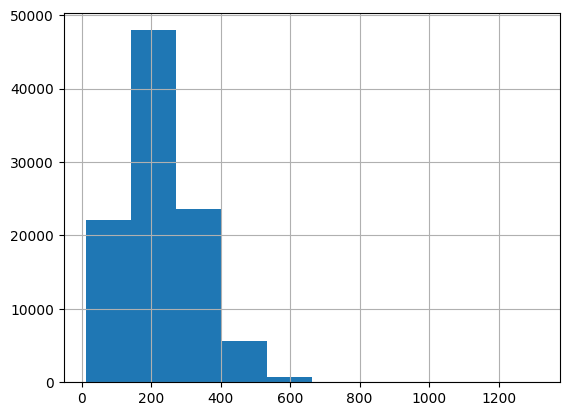

In [9]:
pd.Series(len_of_dBtokens).hist()

In [10]:
pd.Series(len_of_dBtokens).describe().round()

count    100000.0
mean        227.0
std         105.0
min          12.0
25%         149.0
50%         213.0
75%         290.0
max        1311.0
dtype: float64

## Tokenization

In [11]:
# create X and y
features = 'text'
target = 'target'

In [12]:
X_train_raw = training_data[features]
y_train = training_data[target]

In [13]:
X_val_raw = validation_data[features]
y_val = validation_data[target]

In [14]:
X_test_raw = test_data[features]
y_test = test_data[target]

In [16]:
example = X_train_raw.sample(1)

In [18]:
example.iloc[0]

'Singularities of Gauss maps of wave fronts with non-degenerate singular\n  points   We study singularities of Gauss maps of fronts and give characterizations of\ntypes of singularities of Gauss maps by geometric properties of fronts which\nare related to behavior of bounded principal curvatures. Moreover, we\ninvestigate relation between a kind of boundedness of Gaussian curvatures near\ncuspidal edges and types of singularities of Gauss maps of cuspidal edges.\nFurther, we consider extended height functions on fronts with non-degenerate\nsingular points.\n'

In [24]:
tokens = tokenizer.tokenize(example.iloc[0])
print(tokens)

['Sing', '##ular', '##ities', 'of', 'G', '##aus', '##s', 'maps', 'of', 'wave', 'fronts', 'with', 'non', '-', 'de', '##generate', 'singular', 'points', 'We', 'study', 'singular', '##ities', 'of', 'G', '##aus', '##s', 'maps', 'of', 'fronts', 'and', 'give', 'characterization', '##s', 'of', 'types', 'of', 'singular', '##ities', 'of', 'G', '##aus', '##s', 'maps', 'by', 'geometric', 'properties', 'of', 'fronts', 'which', 'are', 'related', 'to', 'behavior', 'of', 'bounded', 'principal', 'cu', '##rva', '##tures', '.', 'Moreover', ',', 'we', 'investigate', 'relation', 'between', 'a', 'kind', 'of', 'bounded', '##ness', 'of', 'G', '##aus', '##sian', 'cu', '##rva', '##tures', 'near', 'cu', '##sp', '##idal', 'edges', 'and', 'types', 'of', 'singular', '##ities', 'of', 'G', '##aus', '##s', 'maps', 'of', 'cu', '##sp', '##idal', 'edges', '.', 'Further', ',', 'we', 'consider', 'extended', 'height', 'functions', 'on', 'fronts', 'with', 'non', '-', 'de', '##generate', 'singular', 'points', '.']


In [25]:
MAX_LENGTH = 256 # LEN OF SEQUENCE

tokenizer = DistilBertTokenizerFast.from_pretrained(TRANSFORMER_MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(docs, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for doc in tqdm(docs):
        inputs = tokenizer.encode_plus(doc, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')



In [26]:
inputs_and_mask = tokenize(example, tokenizer)

100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.45it/s]


In [27]:
inputs_and_mask

(array([[  101, 13315,  5552,  4233,  1104,   144, 25134,  1116,  7415,
          1104,  4003, 25036,  1114,  1664,   118,  1260, 26038, 13794,
          1827,  1284,  2025, 13794,  4233,  1104,   144, 25134,  1116,
          7415,  1104, 25036,  1105,  1660, 27419,  1116,  1104,  3322,
          1104, 13794,  4233,  1104,   144, 25134,  1116,  7415,  1118,
         16735,  4625,  1104, 25036,  1134,  1132,  2272,  1106,  4658,
          1104, 10350,  3981, 16408, 13461, 12463,   119,  9841,   117,
          1195,  8242,  6796,  1206,   170,  1912,  1104, 10350,  1757,
          1104,   144, 25134, 11890, 16408, 13461, 12463,  1485, 16408,
         20080, 13293,  7521,  1105,  3322,  1104, 13794,  4233,  1104,
           144, 25134,  1116,  7415,  1104, 16408, 20080, 13293,  7521,
           119,  6940,   117,  1195,  4615,  2925,  3976,  4226,  1113,
         25036,  1114,  1664,   118,  1260, 26038, 13794,  1827,   119,
           102,     0,     0,     0,     0,     0,     0,     0,

In [33]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [34]:
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [11]:
X_train = tokenize(X_train_raw, tokenizer)

100%|██████████| 70655/70655 [00:49<00:00, 1438.85it/s]


In [12]:
## save to pickle
pickle.dump(X_train, open("../data/wip/dB/X_train_tot_256.pkl", 'wb'))
pickle.dump(y_train, open("../data/wip/dB/y_train_tot_256.pkl", 'wb'))

In [ ]:
X_val = tokenize(X_val_raw, tokenizer)

In [ ]:
## save to pickle
pickle.dump(X_val, open("../data/wip/dB/X_val_tot_256.pkl", 'wb'))
pickle.dump(y_val, open("../data/wip/dB/y_val_tot_256.pkl", 'wb'))

In [12]:
X_test = tokenize(X_test_raw, tokenizer)

100%|██████████| 328562/328562 [03:07<00:00, 1749.22it/s]


In [13]:
## save to pickle
pickle.dump(X_test, open("../data/wip/dB/X_test_tot_256.pkl", 'wb'))
pickle.dump(y_test, open("../data/wip/dB/y_test_tot_256.pkl", 'wb'))